In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as TD
import torch.optim as optim
from torch.distributions import Normal, Bernoulli, Independent
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from collections import defaultdict
from tqdm.notebook import tqdm
from typing import List, Union
import gc
import os
import numpy as np
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from IPython.display import Image, display
from IPython.core.display import HTML
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device='mps'

**Our dataset**

In [3]:
import sys
sys.path.append('../rdas/datasets')
# from rdas.datasets.linear import DatasetGenerator
import linear as ldsg # Linear dataset generator
from torch.utils.data import TensorDataset, DataLoader

In [4]:
class ResBlock(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.func = nn.Sequential(
            nn.Linear(in_dim, 2*in_dim),
            nn.BatchNorm1d(2*in_dim),
            nn.ReLU(),
            nn.Linear(2*in_dim, out_dim),
            nn.BatchNorm1d(out_dim)
        )
        
        self.residual = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()
    def forward(self, x):
        return self.func(x) + self.residual(x)
        

class Encoder(nn.Module):
    def __init__(self, dim: int, latent_dim: int, intermediate_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            ResBlock(dim, dim),
            ResBlock(dim, intermediate_dim),
            ResBlock(intermediate_dim, intermediate_dim),
            ResBlock(intermediate_dim, intermediate_dim),
            ResBlock(intermediate_dim, 2*latent_dim),
        )
    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, dim: int, latent_dim: int, intermediate_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            ResBlock(latent_dim, latent_dim),
            ResBlock(latent_dim, intermediate_dim),
            ResBlock(intermediate_dim, intermediate_dim),
            ResBlock(intermediate_dim, intermediate_dim),
            ResBlock(intermediate_dim, dim),
        )
    def forward(self, z):
        return self.model(z)
    



In [5]:
def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):
    """
        This function should return the value of KL(p1 || p2),
        where p1 = Normal(mean_1, exp(log_std_1)), p2 = Normal(mean_2, exp(log_std_2) ** 2).
        If mean_2 and log_std_2 are None values, we will use standard normal distribution.
        Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)

    std_1 = torch.exp(log_std_1)
    std_2 = torch.exp(log_std_2)

    mean_1, mean_2 = mean_1.float(), mean_2.float()
    std_1, std_2  = std_1.float(), std_2.float()

    p  = Independent(torch.distributions.Normal(mean_1, std_1), 1)
    q  = Independent(torch.distributions.Normal(mean_2, std_2), 1)
    kl = torch.distributions.kl_divergence(p, q)

    return kl


def get_normal_nll(x, mean, log_std):
    """
        This function should return the negative log likelihood log p(x),
        where p(x) = Normal(x | mean, exp(log_std) ** 2).
        Note that we consider the case of diagonal covariance matrix.
    """
    # ====
    mean = mean.float()
    std  = torch.exp(log_std).float()

    prob = Independent(torch.distributions.Normal(mean, std), reinterpreted_batch_ndims = 1)
    nnl = -prob.log_prob(x)
    return nnl

In [6]:
def train_epoch(model, train_loader, optimizer, use_cuda, loss_key='total'):
    model.train()

    stats = defaultdict(list)
    for x in train_loader:
        x = x[0]
        if use_cuda:
            x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(model, data_loader, use_cuda):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            x = x[0]
            if use_cuda:
                x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(
    model,
    train_loader,
    test_loader,
    epochs,
    lr,
    use_tqdm=False,
    use_cuda=False,
    loss_key='total_loss'
):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()

    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, test_loader, use_cuda)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
        print(f"{test_losses['elbo_loss']=}")
        # print(f"{test_losses['kl_loss']=}")
        # print(f"{test_losses['recon_loss']=}")
    return dict(train_losses), dict(test_losses)

In [7]:
class VAE(nn.Module):
    def __init__(self, enc, dec, n_latent, beta=1):
        super().__init__()
        # assert len(input_shape) == 3

        self.beta = beta
        self.n_latent = n_latent
      
        self.encoder = enc
        self.decoder = dec

    def prior(self, n, use_cuda=False):
     
        z = torch.randn(n, self.n_latent)
        if use_cuda:
            z = z.cuda()
        return z

    def forward(self, x):
        mu_z, log_std_z = torch.tensor_split(self.encoder(x), 2, dim = 1)
        # print(mu_z.shape, log_std_z.shape, self.prior(x.shape[0]).shape) # (100, 2) (100, 2) (100, 10)
        z = mu_z + torch.exp(log_std_z) * self.prior(x.shape[0])
        mu_x = self.decoder(z)
        return mu_z, log_std_z, mu_x
        
    def loss(self, x):

        mu_z, log_std_z, mu_x = self(x)
        recon_loss = torch.mean(get_normal_nll(x, mu_x, torch.zeros_like(mu_x)))
        kl_loss = torch.mean(get_normal_KL(mu_z, log_std_z, torch.zeros_like(mu_z), torch.zeros_like(log_std_z)))
        elbo_loss = self.beta * kl_loss + recon_loss
        dict_loss = {"recon_loss": recon_loss, "kl_loss":kl_loss, "elbo_loss":elbo_loss}
        return dict_loss

    def sample(self, n):
        with torch.no_grad():

            x_recon = self.decoder(self.prior(n))
            # samples = torch.clamp(x_recon, -1, 1)

        return x_recon.cpu().numpy()

In [74]:
n_samples = 10000
dim_of_space = 3
dim_of_manifold = 2

d = 2  # dimension of latent space 
nh =  10 # dinesnions of intermediate representations.
# D = dim_of_space # dimension of data space

PATH_DATASET = "/Users/melnikov/Desktop/study/Skoltech/NLA/proj/rdas/datasets/samples/line_3d.txt"
TEST_SIZE = 0.2
BATCH_SIZE = 400

dataset = np.loadtxt(PATH_DATASET, delimiter=',') 
SCALE = np.max(dataset)
dataset = dataset/(0.5*SCALE) - 1

test_dataset = TensorDataset(torch.Tensor(dataset[:int(TEST_SIZE*dataset.shape[0])])) 
train_dataset = TensorDataset(torch.Tensor(dataset[int(TEST_SIZE*dataset.shape[0]):])) 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
D = dataset.shape[1]

# generator = ldsg.DatasetGenerator(dim_of_space, dim_of_manifold)
# dataset = generator.generate_lines_planes(n_samples, scale=300, noise=0, line_params=[1, 1, 1])
# np.random.shuffle(dataset)

# test_dataset = TensorDataset(torch.Tensor(dataset[:int(0.2*n_samples)])) 
# train_dataset = TensorDataset(torch.Tensor(dataset[int(0.2*n_samples):])) 
# test_loader = DataLoader(test_dataset, batch_size=300, shuffle=True)
# train_loader = DataLoader(train_dataset, batch_size=300, shuffle=True)


In [75]:
enc = Encoder(D, d, nh)
dec = Decoder(D, d, nh)
# enc = enc.to(device)
# dec = dec.to(device)

In [76]:
EPOCHS = 30   # < 16
LR = 0.3*1e-3         # < 1e-3
BETA = 1       # 0.1 < _ < 10

model = VAE(enc, dec, d)

train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    loss_key='elbo_loss', 
    use_tqdm=False, 
    use_cuda=False, 
)

test_losses['elbo_loss']=[3.975854983329773]
test_losses['elbo_loss']=[3.975854983329773, 3.262909116744995]
test_losses['elbo_loss']=[3.975854983329773, 3.262909116744995, 3.085520658493042]
test_losses['elbo_loss']=[3.975854983329773, 3.262909116744995, 3.085520658493042, 3.0416821336746214]


KeyboardInterrupt: 

In [61]:
smpls = model.sample(100)

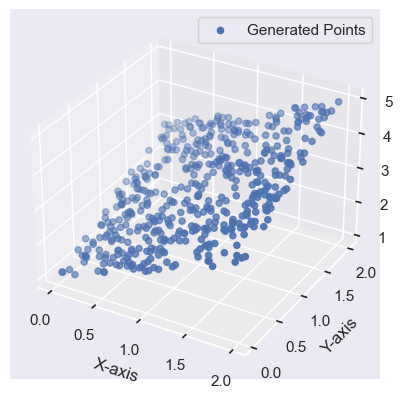

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sns.set()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ds = dataset[:500]
ax.scatter(ds[:, 0], ds[:, 1], ds[:, 2], marker='o', label='Generated Points')

# ax.scatter(smpls[:, 0], smpls[:, 1], smpls[:, 2], marker='x', label='Generated Points')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend()

plt.show()

In [63]:
import plotly.express as px
# df = px.data.iris()
# fig = px.scatter_3d(x=ds[:,0], y=ds[:,1], z=ds[:,2])
fig = px.scatter_3d(x=smpls[:, 0], y=smpls[:, 1], z=smpls[:, 2])
fig.show()
fig.write_html("./file.html")